In [1]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Global configuration

In [3]:
TEST_SIZE = 0.2
RANDOM_SEED = 42
MODEL_FILENAME = 'genre_multimodal.pkl'

COL_TITLE = 'Title'
COL_AUTHOR = 'Author'
COL_LOCATION = 'Location'
COL_DATE = 'Date'
COL_TARGET = 'Genre'

Feature preprocessing

In [5]:
title_transformer = TfidfVectorizer( # applies a transformer 
    ngram_range=(1, 2),
    max_df=0.7, # ignores words appearing in more than 70% of the corpus
    stop_words='english'
)

categorical_transformer = OneHotEncoder( # one-hot encoding for categorical metadata
    handle_unknown='ignore',
    sparse_output=False
)

numerical_transformer = StandardScaler() # standardizes numerical data

preprocessor = ColumnTransformer( # applies transformation on resepective columns
    transformers=[
        ('text', title_transformer, COL_TITLE),
        ('cat', categorical_transformer, [COL_AUTHOR, COL_LOCATION]),
        ('date', numerical_transformer, [COL_DATE])
    ],
    remainder='drop'
)

Load and prepare data

In [7]:
df = pd.read_csv('./data/training_data.csv')
df.dropna(
    subset=[COL_TARGET, COL_TITLE, COL_AUTHOR, COL_LOCATION, COL_DATE],
    inplace=True
) # drop rows with missing values 
X = df.drop(COL_TARGET, axis=1) # features 
y = df[COL_TARGET] # target label
print(f"Total usable samples: {len(y)}")

Total usable samples: 15091


Split into training and testing sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split( # shuffles and splits the data
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y # keeps same proportion of genre in training and testing sets
)
print(f"Training samples: {len(y_train)}")
print(f"Testing samples : {len(y_test)}")

Training samples: 12072
Testing samples : 3019


Model pipeline

In [11]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC( 
        C=1.0,
        class_weight='balanced', # adjusts for genres that are not well represented
        random_state=RANDOM_SEED
    ))
])

Training phase

In [13]:
pipeline.fit(X_train, y_train)
print("Cross-validation (5-fold) on training set:")
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5) # divides the model in 5 folds and tests 5 times
print(f"Scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation (5-fold) on training set:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scores: [0.94078675 0.93498965 0.93247722 0.94159072 0.94159072]
Mean CV accuracy: 0.9383


Testing phase

In [15]:
test_accuracy = pipeline.score(X_test, y_test)
print(f"Final test accuracy: {test_accuracy:.4f}")
y_pred = pipeline.predict(X_test) # predicts genre for the test set

Final test accuracy: 0.9457


Classification report

In [17]:
print("Classification report:")
print(classification_report(y_test, y_pred, zero_division=0))

Classification report:
              precision    recall  f1-score   support

       Drama       0.94      0.89      0.91       268
       Music       0.93      0.81      0.87       128
      Poetry       0.94      0.90      0.92       859
       Prose       0.95      0.99      0.97      1764

    accuracy                           0.95      3019
   macro avg       0.94      0.90      0.92      3019
weighted avg       0.95      0.95      0.94      3019



Normalized confusion matrix

In [19]:
labels = pipeline.classes_
cm_norm = confusion_matrix(
    y_test,
    y_pred,
    labels=labels,
    normalize='true'
)
cm_df = pd.DataFrame(cm_norm, index=labels, columns=labels)
print("Normalized confusion matrix (rows = true labels):")
print(cm_df.round(2))

Normalized confusion matrix (rows = true labels):
        Drama  Music  Poetry  Prose
Drama    0.89   0.00    0.06   0.05
Music    0.03   0.81    0.08   0.08
Poetry   0.01   0.01    0.90   0.08
Prose    0.00   0.00    0.01   0.99


Plot the confusion matrix

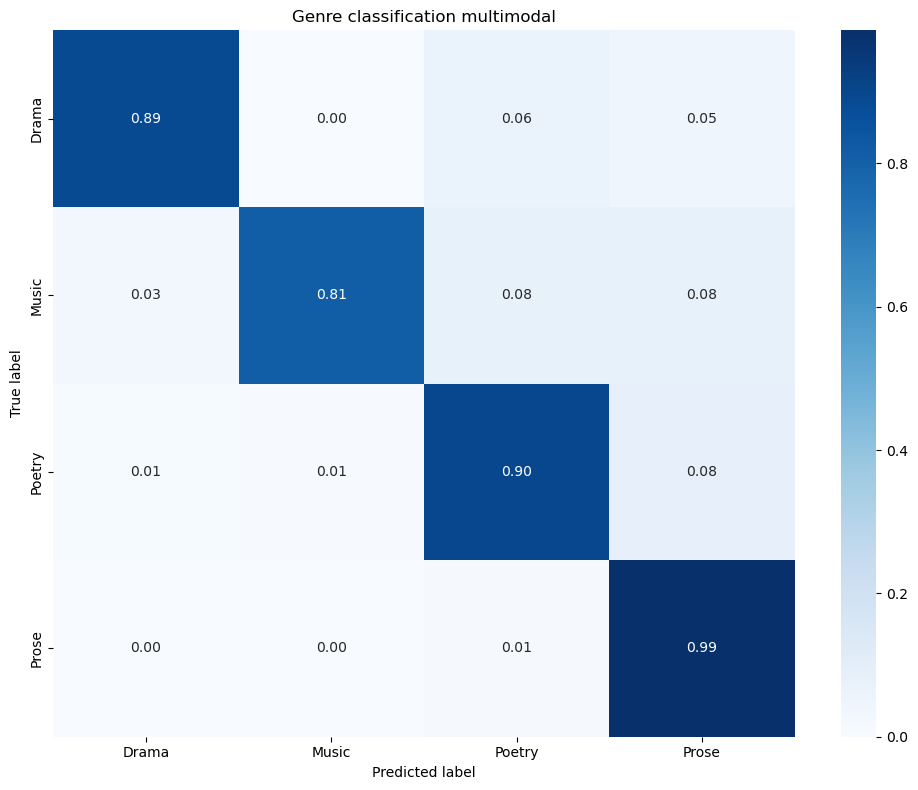

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Genre classification multimodal")
plt.tight_layout()
plt.show()

Uncertainty measures, based on SVM decisions margin

In [23]:
decision_scores = pipeline.decision_function(X_test) # gets decision score for each class
sorted_scores = np.sort(decision_scores, axis=1)
margins = sorted_scores[:, -1] - sorted_scores[:, -2] # margin uncertainty = difference between the highest and second highest score 
uncertainty_df = pd.DataFrame({
    "true_label": y_test.values,
    "predicted_label": y_pred,
    "margin": margins
}).sort_values("margin")
print("Most uncertain predictions (lowest margins):")
print(uncertainty_df.head(10))

Most uncertain predictions (lowest margins):
     true_label predicted_label    margin
2196     Poetry          Poetry  0.001026
1665      Drama          Poetry  0.004457
2791      Music           Music  0.010174
2413      Music          Poetry  0.010305
2955      Prose          Poetry  0.013668
1522     Poetry           Prose  0.020051
2874      Prose           Prose  0.024470
2511      Prose          Poetry  0.025500
1085     Poetry           Music  0.026262
1643      Prose          Poetry  0.027859


Plot the uncertainty measures

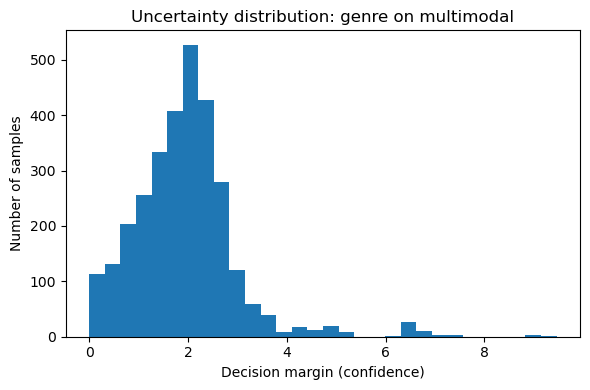

In [25]:
plt.figure(figsize=(6, 4))
plt.hist(margins, bins=30)
plt.xlabel("Decision margin (confidence)")
plt.ylabel("Number of samples")
plt.title("Uncertainty distribution: genre on multimodal")
plt.tight_layout()
plt.show()

Save the model

In [27]:
joblib.dump(pipeline, MODEL_FILENAME)
print(f"Model saved to: {MODEL_FILENAME}")

Model saved to: genre_multimodal.pkl
